In [3]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#try to rewrite using xarray
'''Using initial grid coordinates  (with masked out low concentration values) as trackers 
   displacing them according to the drift values and then in next iteration 
   applying interpolated hourly drift values to new position coordinates. 
'''   
#?? Why do we need to mask out low concentration values?
'''
Tasks:
1. Apply for Barents2.5 model data (using xarray)
2. Implement ratios for teh first and final iterations so it would use SAR1 and SAR2 timestemps
3. Prepare output for alignment run (arrays with lon1, lat1, lon2, lat2)
'''

In [11]:
# Upload the netcdf file
# https://data.marine.copernicus.eu/product/ARCTIC_ANALYSISFORECAST_PHY_ICE_002_011/description
#ifile = '/data1/antonk/tmp/20230531_hr-nersc-MODEL-nextsimf-ARC-b20230524-fv00.0.nc'
ifile = r'C:\Anna\Model_data\NEXTSIM_model\20221119_hr-nersc-MODEL-nextsimf-ARC-b20221120-fv00.0.nc'

# Set space and time steps (20 is better for visualizing, for all data "space_step = 1")
space_step = 20
time_step = 1

# Extract netcdf variables
with Dataset(ifile) as ds:
    # Extracting coordinates
    x = ds['x'][::space_step]
    y = ds['y'][::space_step]
    # Extracting sea ice concentrations
    siconc = ds['siconc'][::time_step, ::space_step, ::space_step]
    # Extracting ice drif velocity along the x and y axes
    # .filled(np.nan) is replacing the missing (absent) values with NaN (Not a Number) values 
    vxsi = ds['vxsi'][::time_step, ::space_step, ::space_step].filled(np.nan)
    vysi = ds['vysi'][::time_step, ::space_step, ::space_step].filled(np.nan)
    # Extracting time
    time = ds['time'][::time_step]
    time_bnds = ds['time_bnds'][::time_step]

print(x.shape, y.shape, siconc.shape, vxsi.shape, time.shape)

(124,) (119,) (24, 119, 124) (24, 119, 124) (24,)


In [5]:
time_bnds[0], time_bnds[0].mean(), time[0]

(masked_array(data=[44882.        , 44882.04166667],
              mask=False,
        fill_value=1e+20),
 44882.02083333333,
 44882.02083333333)

In [13]:
# Replace NaN values with zeros. Helps to avoid extreme values near land, it just stops
vxsi[np.isnan(vxsi)] = 0
vysi[np.isnan(vysi)] = 0

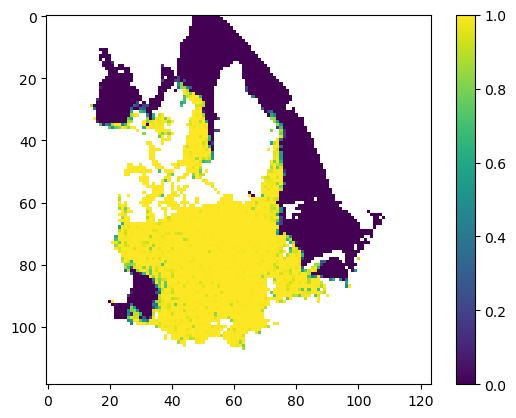

In [14]:
plt.imshow(siconc[0])
plt.colorbar()

In [10]:
delta_t = np.diff(time)
delta_t

masked_array(data=[0.04166667, 0.04166667, 0.04166667, 0.04166667,
                   0.04166667, 0.04166667, 0.04166667, 0.04166667,
                   0.04166667, 0.04166667, 0.04166667, 0.04166667,
                   0.04166667, 0.04166667, 0.04166667, 0.04166667,
                   0.04166667, 0.04166667, 0.04166667, 0.04166667,
                   0.04166667, 0.04166667, 0.04166667],
             mask=False,
       fill_value=1e+20)

In [45]:
# Set minimum concentration for masking
min_conc = 0.15

# 
delta_t = np.diff(time)*24*60*60

# Prepare a mask with low and zero concentration
mask = np.where(siconc[0] > min_conc)

# Create coordinate arrays  
x_stp, y_stp = np.meshgrid(x, y)
# Turn arrays into vectors and mas out values with low and zero concentration
x_stp = x_stp[mask]
y_stp = y_stp[mask]

# Store the selected coordinate arrays in lists to collect arrays from different iterationsfor further processing
xx = [x_stp]
yy = [y_stp]

In [54]:
vxsi[23].shape

(119, 124)

In [55]:
# Iterate through hourly data to move trackers through the whole period 
for i in range(23):
    # Create interpolator object with grid coordinates and corresponded drift values
    vxi_interpolator = RegularGridInterpolator((y,x), vxsi[i])
    vyi_interpolator = RegularGridInterpolator((y,x), vysi[i])
    # Apply interpolator object as function to calculate interpolated velocity values for new coordinates
    # y_stp, x_step correspond to original masked grid coordinated at fist iteration
    vxsi_new = vxi((y_stp, x_stp))
    vysi_new = vyi((y_stp, x_stp)) 
    # Calculate displacement
    dx = vxsi_new*delta_t[i]
    dy = vysi_new*delta_t[i]
    # Calculate new coordinates  y_stp, x_step for next iteration
    x_stp = x_stp + dx
    y_stp = y_stp + dy
    # Append them to the list
    xx.append(x_stp)
    yy.append(y_stp)


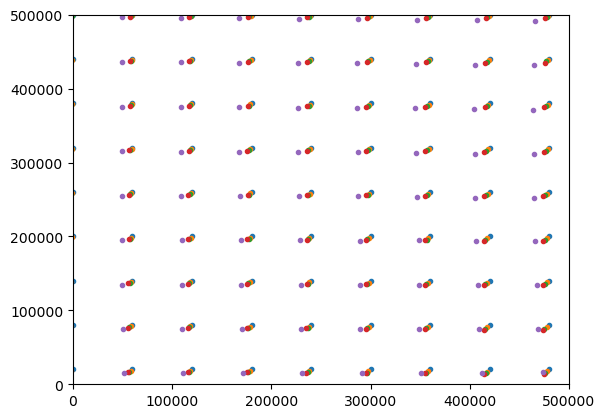

In [57]:
plt.plot(xx[0], yy[0], '.')
plt.plot(xx[6], yy[6], '.')
plt.plot(xx[12], yy[12], '.')
plt.plot(xx[18], yy[18], '.')
plt.plot(xx[-1], yy[-1], '.')
plt.xlim([0, 5e5])
plt.ylim([0, 5e5])
plt.show()